# How Businesses Know What Offers to Give You

Have you ever wondered how businesses seem to know exactly when to send you that discount or offer?
Whether it's a reward for being a loyal customer or an attempt to win you back after a while, the magic lies in something called RFM analysis.

RFM stands for Recency, Frequency, and Monetary Value, it's a powerful way businesses analyze customer behavior to create targeted strategies. In this project, I'll show you how to perform RFM analysis using Python, from raw data to acutal customer insights.

In [ ]:
 import pandas as pd

#to load my data 
data = r'C:\Users\INIOLUWA\Downloads\Customers data.csv'
df = pd.read_csv(data)

In [2]:
# Check for missing values
print(df.isnull().sum())


TransactionID       0
Customer-ID         0
PurchaseAmount      0
PurchaseDate        0
PurchaseTime        0
ProductID           0
PurchaseQuantity    0
dtype: int64


In [3]:
# Ensure 'PurchaseDate' is in datetime format
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])

# Confirm the data types
print(df.dtypes)

TransactionID                int64
Customer-ID                 object
PurchaseAmount               int64
PurchaseDate        datetime64[ns]
PurchaseTime                object
ProductID                   object
PurchaseQuantity             int64
dtype: object


In [4]:
#use todays's date as my snaphshot date
snapshot_date = pd.Timestamp('2024-11-18')

In [5]:
# Aggregate data to create the RFM table
rfm = df.groupby('Customer-ID').agg({
    # Recency
    'PurchaseDate': lambda x: (snapshot_date - x.max()).days,
    # Frequency
    'Customer-ID': 'count',
    # Monetary Value
    'PurchaseAmount': 'sum'
}).rename(columns={
    'PurchaseDate': 'Recency',
    'Customer-ID': 'Frequency',
    'PurchaseAmount': 'MonetaryValue'
}).reset_index()

print(rfm.head())


    Customer-ID  Recency  Frequency  MonetaryValue
0    CUSTIDXX-0      150          2            419
1    CUSTIDXX-1        4         16           9815
2   CUSTIDXX-10      280          1            659
3  CUSTIDXX-100       39          1            187
4  CUSTIDXX-101       38          1            970


In [6]:
print(rfm.head(200))

      Customer-ID  Recency  Frequency  MonetaryValue
0      CUSTIDXX-0      150          2            419
1      CUSTIDXX-1        4         16           9815
2     CUSTIDXX-10      280          1            659
3    CUSTIDXX-100       39          1            187
4    CUSTIDXX-101       38          1            970
..            ...      ...        ...            ...
128   CUSTIDXX-93       46          1           1038
129   CUSTIDXX-95       44          1            649
130   CUSTIDXX-97       42          1            523
131   CUSTIDXX-98       41          1            440
132   CUSTIDXX-99       40          1             75

[133 rows x 4 columns]


In [7]:

# BIN 1: Recency (Lower values are better)
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=[4, 3, 2, 1], duplicates='drop')

# BIN 2: Frequency (Higher values are better)
unique_bins = len(pd.qcut(rfm['Frequency'], q=4, retbins=True, duplicates='drop')[1]) - 1
rfm['F_Score'] = pd.qcut(rfm['Frequency'], q=unique_bins, labels=range(1, unique_bins + 1))

# BIN 3: Monetary Value (Higher values are better)
unique_bins = len(pd.qcut(rfm['MonetaryValue'], q=4, retbins=True, duplicates='drop')[1]) - 1
rfm['M_Score'] = pd.qcut(rfm['MonetaryValue'], q=unique_bins, labels=range(1, unique_bins + 1))

# Combine R, F, M scores into a single RFM Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Display the updated dataframe
print(rfm.head())


    Customer-ID  Recency  Frequency  MonetaryValue R_Score F_Score M_Score  \
0    CUSTIDXX-0      150          2            419       2       1       1   
1    CUSTIDXX-1        4         16           9815       4       1       4   
2   CUSTIDXX-10      280          1            659       1       1       2   
3  CUSTIDXX-100       39          1            187       4       1       1   
4  CUSTIDXX-101       38          1            970       4       1       3   

  RFM_Score  
0       211  
1       414  
2       112  
3       411  
4       413  


In [8]:
# Segment customers based on RFM_Score
def segment_customer(rfm_score):
    if rfm_score == '444':
        return 'Champions'
    elif rfm_score[0] == '4':  # High Recency Score
        return 'Loyal Customers'
    elif rfm_score[1] == '4':  # High Frequency Score
        return 'Frequent Buyers'
    elif rfm_score[2] == '4':  # High Monetary Score
        return 'Big Spenders'
    elif rfm_score[0] == '1':  # Low Recency Score
        return 'At Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)
print(rfm[['RFM_Score', 'Segment']].head())


  RFM_Score          Segment
0       211           Others
1       414  Loyal Customers
2       112          At Risk
3       411  Loyal Customers
4       413  Loyal Customers


In [11]:
# Analyze customer segments
segment_analysis = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
     # Number of customers per segment
    'Customer-ID': 'count' 
}).rename(columns={'Customer-ID': 'CustomerCount'})

print(segment_analysis)


                    Recency  Frequency  MonetaryValue  CustomerCount
Segment                                                             
At Risk          273.214286   1.000000     664.214286             28
Big Spenders     181.500000   1.500000    1901.166667             18
Loyal Customers   21.117647   2.617647    2166.117647             34
Others           158.094340   1.037736     654.509434             53


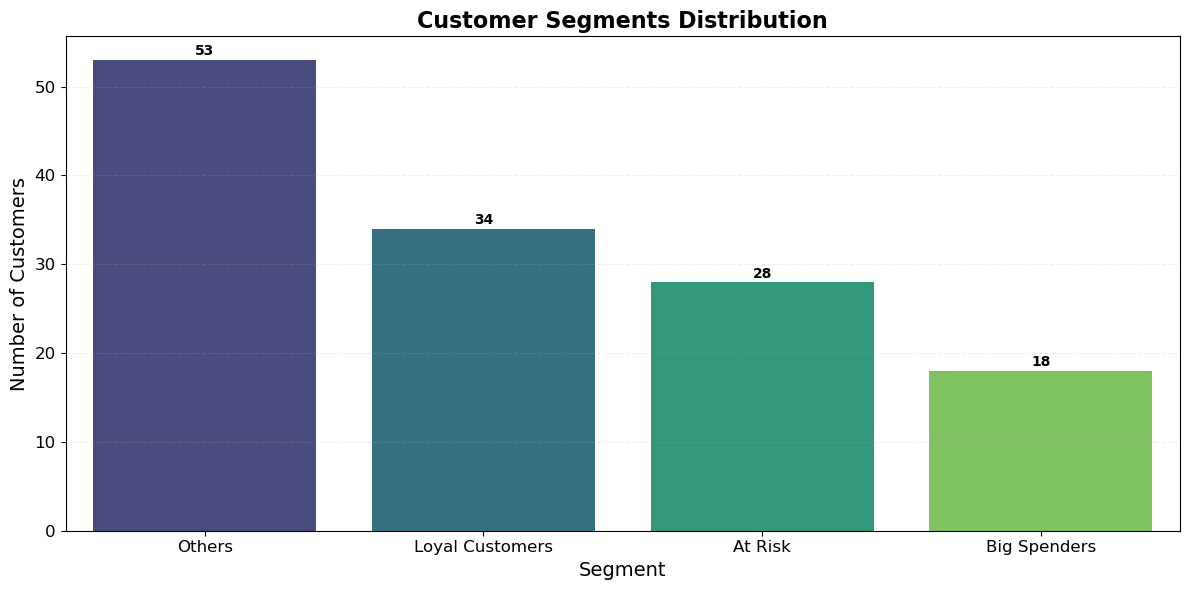

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart of customer segments with data points
plt.figure(figsize=(12, 6))
sns.barplot(
    x=segment_analysis['CustomerCount'].sort_values(ascending=False).index,
    y=segment_analysis['CustomerCount'].sort_values(ascending=False),
    palette="viridis"
)

# Add data points on top of bars
for i, value in enumerate(segment_analysis['CustomerCount'].sort_values(ascending=False)):
    plt.text(
        # x-coordinate of the text
        i, 
         # y-coordinate (slightly above the bar)
        value + 0.5, 
         # Text to display (the value)
        str(value),           
        # Horizontal alignment
        ha='center',
        # Font size
        fontsize=10,
         # Text color
        color='black',
           # Bold font
        fontweight='bold'   
    )

# To Improve my visuals
plt.title('Customer Segments Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Segment', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.xticks(fontsize=12, rotation=0)  
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.2)

# Display the chart
plt.tight_layout()
plt.show()


To allow me export my results to a CSV file for further use or sharing

In [12]:
rfm.to_csv('rfm_segmentation_results.csv', index=False)
